In [3]:
import kagglehub
masoudnickparvar_brain_tumor_mri_dataset_path = kagglehub.dataset_download('masoudnickparvar/brain-tumor-mri-dataset')

print('Data source import complete.')


Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Data source import complete.


# UNet model + pre-trained VGG-11, Grad-CAM for explainability
This notebook proposes a model for classifying images from the Brain Tumor MRI Dataset, which contains three types of tumors and images without tumors. We will train it for 50 epochs, but we will use Early Stopping to stop training early if the F1 score on the validation set does not improve over several consecutive epochs. Finally, we will evaluate the model on the validation set, presenting various metrics and the confusion matrix of the test set.

Instead of opening the image as RGB and resizing it to 224, we will use an encoder-decoder to obtain three channels by opening the image as grayscale and an AdaptiveAvgPool2d to scale the image to the 224x224 size required by the VGG pre-trained with Imagenet.

In the last part of the notebook, after evaluating the model, we use Gradient-weighted Class Activation Mapping (Gradient-CAM) to assess the model's explainability.

In [4]:
import random
from collections import Counter
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             precision_score, recall_score, accuracy_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import transforms
from torchvision.models import VGG11_BN_Weights, vgg11_bn

In [5]:
DATA = "/kaggle/input/brain-tumor-mri-dataset"
SEED = 42

### Data upload


In [6]:
data_folder = Path(DATA)

train_df = pd.DataFrame(columns=["image", "label"])
test_df = pd.DataFrame(columns=["image", "label"])

for folder in (data_folder / "Training").iterdir():
    temp_df = pd.DataFrame(columns=["image", "label"])
    temp_df["image"] = [image for image in folder.iterdir()]
    temp_df["label"] = folder.parts[-1]
    train_df = pd.concat([train_df, temp_df], ignore_index=True)
    del temp_df

for folder in (data_folder / "Testing").iterdir():
    temp_df = pd.DataFrame(columns=["image", "label"])
    temp_df["image"] = [image for image in folder.iterdir()]
    temp_df["label"] = folder.parts[-1]
    test_df = pd.concat([test_df, temp_df], ignore_index=True)
    del temp_df

In [7]:
train_df = train_df.sample(frac=1, random_state=SEED, ignore_index=True)
test_df = test_df.sample(frac=1, random_state=SEED, ignore_index=True)

### Function for visualizing distributions


In [8]:
def plot_distribution(array, title):
    # Calculate the distribution
    hist = Counter(array)
    categories = sorted(hist.keys(), key=lambda x: hist[x], reverse=True)
    frequencies = [hist[cat] for cat in categories]

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Convert categories and frequencies to NumPy arrays
    categories_np = np.array([str(cat) for cat in categories])
    frequencies_np = np.array(frequencies)

    df = pd.DataFrame({"Category": categories_np, "Frequency": frequencies_np})

    # Bar chart with seaborn
    sns.barplot(x="Category", y="Frequency", data=df, ax=ax1)
    ax1.set_title("Distribution")
    ax1.set_xlabel("Category")
    ax1.set_ylabel("Frecuency")
    ax1.tick_params(axis="x", rotation=45)

    # Add the number of items above each bar
    for i, freq in enumerate(frequencies_np):
        ax1.text(i, freq + 0.1, str(freq), ha="center", va="bottom", fontsize=10)

    max_freq = np.max(frequencies_np)
    ax1.set_ylim(0, max_freq * 1.1)  # Add 10% extra space

    # Pie chart (percentages) with matplotlib
    ax2.pie(
        frequencies_np,
        labels=categories_np,
        autopct="%1.1f%%",
    )
    ax2.set_title("Percentages")

    # General title
    fig.suptitle(title)

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

### Visualization of the class distribution


In [9]:
# Creation of the validation set
X_train, X_val, y_train, y_val = train_test_split(
    train_df["image"].to_numpy(),
    train_df["label"].to_numpy(),
    train_size=0.7,
    random_state=SEED,
    stratify=train_df["label"],
)

X_test, y_test = test_df.to_numpy().T

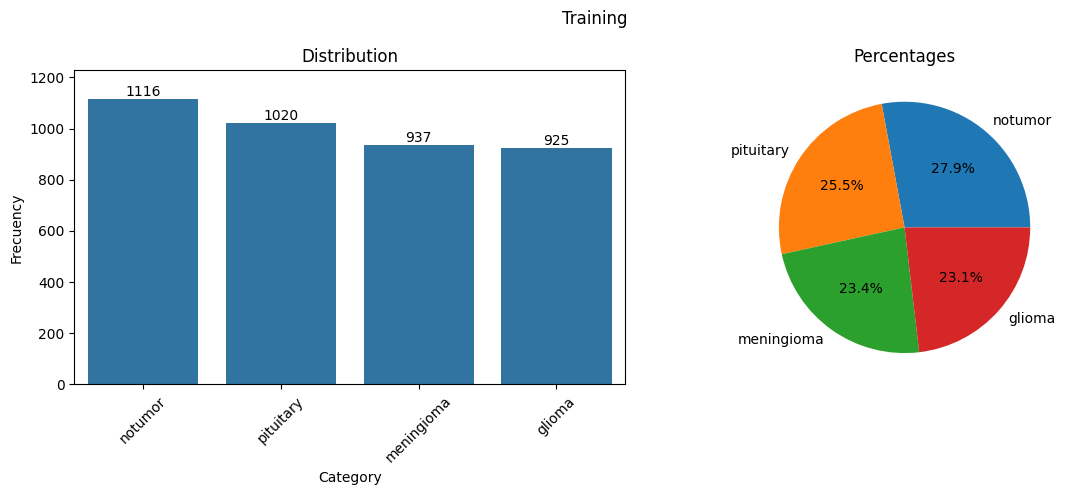

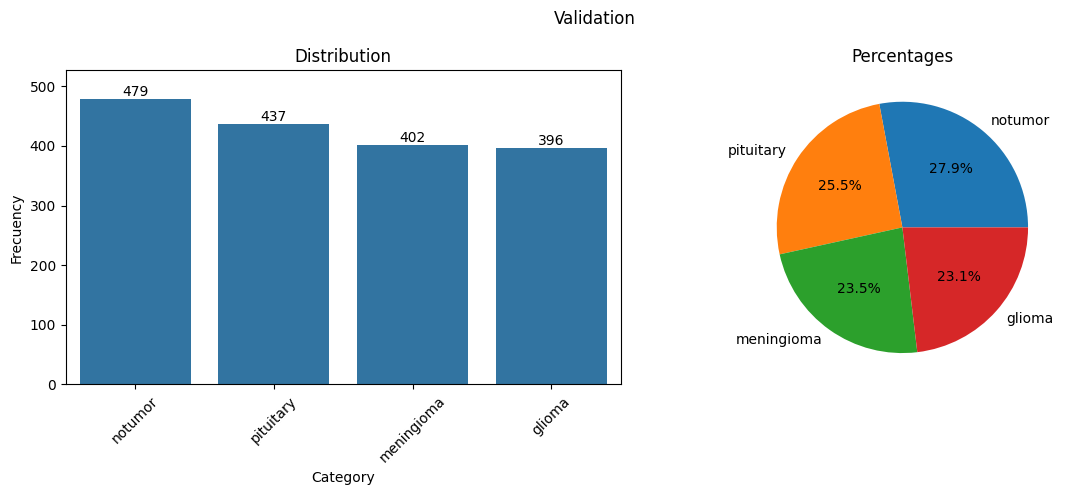

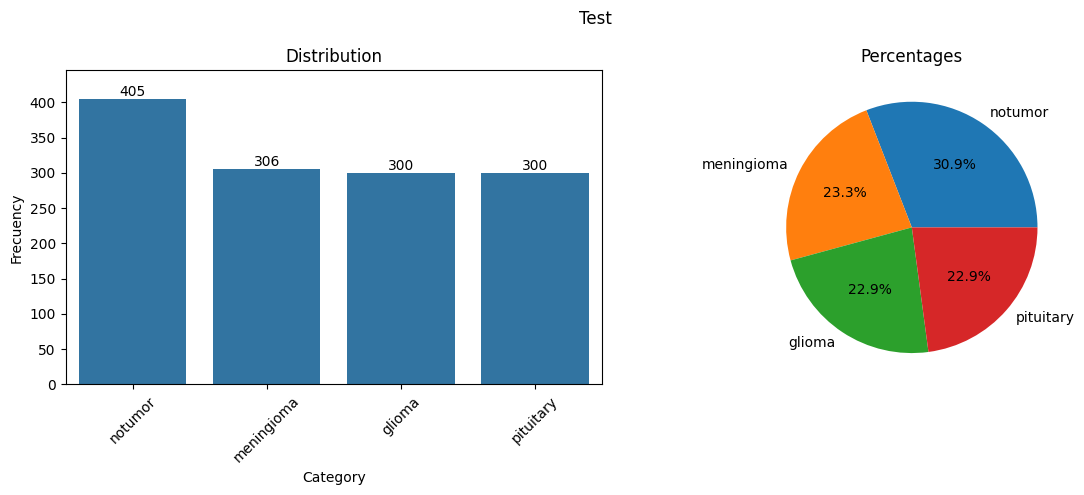

In [10]:
plot_distribution(y_train, "Training")
plot_distribution(y_val, "Validation")
plot_distribution(y_test, "Test")

In [11]:
sum_pixels = 0.0
sum_squared_pixels = 0.0
total_pixels = 0

for img_path in X_train:
    # Open grayscale image
    img = Image.open(img_path).convert("L")

    # Normalize to [0, 1]
    img_array = np.array(img) / 255.0
    img_flat = img_array.flatten()

    # Accumulate statistics
    n_pixels = len(img_flat)
    sum_pixels += np.sum(img_flat)
    sum_squared_pixels += np.sum(img_flat ** 2)
    total_pixels += n_pixels

# Calculate mean and standard deviation
mean = sum_pixels / total_pixels
std = np.sqrt((sum_squared_pixels / total_pixels) - mean ** 2)

print(f"Pixel Average: {mean:.2f} +- {std:.2f}")

Pixel Average: 0.17 +- 0.19


### Label coding
`LabelEncoder` is used to convert text labels into numeric values.

In [12]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

### Creating a PyTorch Dataset
A `BrainTumorDataset` class is defined that converts images and labels into a PyTorch-compatible dataset. This class allows data augmentation to be applied to the images if specified.

In [13]:
# Convert the images and labels to a PyTorch Dataset
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image using PIL
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("L")

        if self.transform:
            # Apply transformations
            image = self.transform(image)
        else:
            # If there is no transformation, manually convert to tensor [1, H, W]
            image = torch.from_numpy(np.array(image)).float().unsqueeze(0)

        label = self.labels[idx]

        return image, label

### Data transformations
Two sets of transformations are defined:
- **Training (`train_transform`)**: Includes data augmentation (rotations, scaling, flipping) to improve the model's generalizability.

- **Validation and test (`val_test_transform`)**: Only converts images to tensors, without data augmentation, to evaluate the model consistently.

In [14]:
# Transformations for data augmentation
train_transform = transforms.Compose(
    [
        transforms.Resize(512),
        transforms.RandomHorizontalFlip(
            p=0.5
        ),  # Random horizontal flip (50% probability)
        transforms.RandomRotation(10),  # Random rotation of +/- 10 degrees
        transforms.RandomAffine(
            degrees=0, translate=(0.1, 0.1)
        ),  # Random translation (up to 10%)
        transforms.CenterCrop(
            512
        ),  #Central clipping after random transformations
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[mean], std=[std]
        ),  # Normalization on [-1, 1]
    ]
)


# Transformations for the validation and test sets (without data augmentation)
val_test_transform = transforms.Compose(
    [
        transforms.Resize(512),
        transforms.CenterCrop(512),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean], std=[std]),
    ]
)

In [15]:
# Crear datasets
train_dataset = BrainTumorDataset(X_train, y_train, transform=train_transform)
val_dataset = BrainTumorDataset(X_val, y_val, transform=val_test_transform)
test_dataset = BrainTumorDataset(X_test, y_test, transform=val_test_transform)

# Model
###UNet definition for adapting images

In [16]:
class UNetAdapter(nn.Module):
    def __init__(self):
        super().__init__()

        # --- Contraction (Encoder) ---
        self.enc1 = self._block(1, 32, stride=2)  # 512x512 → 256x256
        self.enc2 = self._block(32, 64, stride=2)  # 256x256 → 128x128
        self.enc3 = self._block(64, 128, stride=2)  # 128x128 → 64x64
        self.enc4 = self._block(128, 256, stride=2)  # 64x64 → 32x32

        # --- Bottleneck ---
        self.bottleneck = self._block(256, 512, stride=2)  # 32x32 → 16x16

        # --- Expansion (Decoder) ---
        self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec4 = self._block(512, 256)  # 32x32
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = self._block(256, 128)  # 64x64
        self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = self._block(128, 64)  # 128x128
        self.upconv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = self._block(64, 32)  # 256x256

        # --- Final layer ---
        self.final_conv = nn.Conv2d(32, 3, kernel_size=1)  # 256x256 → 3 channels
        self.resize = nn.AdaptiveAvgPool2d(224)  # Adjust to 224x224
        self.norm = nn.BatchNorm2d(3)  # Standardization

    def _block(self, in_channels, out_channels, stride=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)  # (C, H, W): (1, 512, 512) → (32, 256, 256)
        e2 = self.enc2(e1)  # (32, 256, 256) → (64, 128, 128)
        e3 = self.enc3(e2)  # (64, 128, 128) → (128, 64, 64)
        e4 = self.enc4(e3)  # (128, 64, 64) → (256, 32, 32)

        # Bottleneck
        bn = self.bottleneck(e4)  # (256, 32, 32) → (512, 16, 16)

        # Decoder (concatenate skip connections)
        d4 = self.upconv4(bn)  # (512, 16, 16) → (256, 32, 32)
        d4 = torch.cat((d4, e4), dim=1)  # Concatenate with e4 (256+256=512 channels)
        d4 = self.dec4(d4)  # (512, 32, 32) → (256, 32, 32)

        d3 = self.upconv3(d4)  # (256, 32, 32) → (128, 64, 64)
        d3 = torch.cat((d3, e3), dim=1)  # 128 + 128 = 256
        d3 = self.dec3(d3)  # (256, 64, 64) → (128, 64, 64)

        d2 = self.upconv2(d3)  # (128, 64, 64) → (64, 128, 128)
        d2 = torch.cat((d2, e2), dim=1)  # 64 + 64 = 128
        d2 = self.dec2(d2)  # (128, 128, 128) → (64, 128, 128)

        d1 = self.upconv1(d2)  # (64, 128, 128) → (32, 256, 256)
        d1 = torch.cat((d1, e1), dim=1)  # 32 + 32 = 64
        d1 = self.dec1(d1)  # (64, 256, 256) → (32, 256, 256)      # 64 → 32, 256→256

        # final departure
        out = self.final_conv(d1)  # 32 → 3 channels
        out = self.resize(out)  # 256x256 → 224x224
        out = self.norm(out)  # Standardization

        return out

### Device setup and seeds
The device is defined to use GPU if available, and the seeds are set to ensure reproducibility of the results.

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Fix seeds for reproducibility
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

### Model instantiation and architecture summary
The sequential model (`UNetAdapter` + `VGG-11`) is created and moved to the corresponding device (`device`). Then, `summary` is used to obtain a summary of the model's architecture, including the number of parameters and the dimensions of each layer.

In [18]:
# We loaded the Imagenet weights
weights = VGG11_BN_Weights.IMAGENET1K_V1

# Instantiate the pretrained VGG-11
vgg = vgg11_bn(weights=weights)

# We adapt the last layer to the number of classes
vgg.classifier[-1] = nn.Linear(2**12, num_classes)

model = nn.Sequential(
    UNetAdapter(), vgg  # 1 channel → 3 channels, 512x512 → 224x22, #VGG-11 pretrained
).to(device)

summary(model, (1, 512, 512))

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


100%|██████████| 507M/507M [00:04<00:00, 107MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             320
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
            Conv2d-4         [-1, 64, 128, 128]          18,496
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7          [-1, 128, 64, 64]          73,856
       BatchNorm2d-8          [-1, 128, 64, 64]             256
              ReLU-9          [-1, 128, 64, 64]               0
           Conv2d-10          [-1, 256, 32, 32]         295,168
      BatchNorm2d-11          [-1, 256, 32, 32]             512
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 512, 16, 16]       1,180,160
      BatchNorm2d-14          [-1, 512,

### Definition of hyperparameters
The key hyperparameters for training the model, obtained using AutoML, are defined. We will set 50 epochs, although the model may stop earlier due to early stopping.

In [19]:
# Hyperparameters
num_epochs = 50
batch_size = 64
learning_rate = 0.001

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Model training

Let's define Early Stopping.

In [20]:
class EarlyStopping:
    """
   Early stopping to minimize loss.

    Args:

    patience: Time to wait without improvement before stopping (default: 5)

    min_delta: Minimum change in val_loss to consider improvement (default: 0.01)

    checkpoint_path: Path to save the best model (default: 'best_model.pth')
    """

    def __init__(
        self,
        patience: int = 5,
        min_delta: float = 0.01,
        checkpoint_path: str = "best_model.pth",
    ):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.checkpoint_path = Path(checkpoint_path)
        self.checkpoint_path.parent.mkdir(exist_ok=True)  # Create directory if it does not exist

    def __call__(self, current_loss: float, model: nn.Module) -> bool:
        """
          Check if there is an improvement in the loss.

          Returns:

          bool: True if training should be stopped
        """
        if self.best_loss is None:
            # First period, we kept the model
            self.best_loss = current_loss
            self._save_model(model)
            return False

        if current_loss > self.best_loss - self.min_delta:
            # There is not enough improvement
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            # The loss improved, we kept the new, better model
            self.best_loss = current_loss
            self._save_model(model)
            self.counter = 0

        return self.early_stop

    def _save_model(self, model: nn.Module):
        """Save the model to disk"""
        torch.save(model.state_dict(), self.checkpoint_path)

    def load_best_model(self, model: nn.Module) -> nn.Module:
        """Load the best stored weights"""
        if self.checkpoint_path.exists():
            model.load_state_dict(torch.load(self.checkpoint_path, weights_only=True))
        return model

In [21]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

We trained the model. We configured early stopping to halt training if the validation loss did not improve by 0.001 over 10 consecutive epochs, saving the model before it stalled.

In addition, we added *ReduceLROnPlateau* with a patience of 3 and a factor of 0.5. This means that if the model did not improve over 3 epochs, the learning rate was halved.

In [22]:
# Lists for storing metrics
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1s = []

val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

# Training
early_stopping = EarlyStopping(patience=10, min_delta=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=3, factor=0.5)

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    all_train_preds = []
    all_train_labels = []
    all_train_probs = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        # Apply softmax and obtain predictions
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels.cpu().numpy())
        all_train_probs.extend(probs.cpu().detach().numpy())

    # Calculate training metrics
    train_loss = epoch_train_loss / len(train_loader)
    train_acc = accuracy_score(all_train_labels, all_train_preds)
    train_precision = precision_score(
        all_train_labels, all_train_preds, average="weighted", zero_division=0
    )
    train_recall = recall_score(
        all_train_labels, all_train_preds, average="weighted", zero_division=0
    )
    train_f1 = f1_score(
        all_train_labels, all_train_preds, average="weighted", zero_division=0
    )

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1s.append(train_f1)

    # Validation
    model.eval()
    epoch_val_loss = 0
    all_val_preds = []
    all_val_labels = []
    all_val_probs = []

    with torch.no_grad(), torch.autocast(device.type, dtype=torch.float16):
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            epoch_val_loss += loss.item()

            # Apply softmax and obtain predictions
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)

            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
            all_val_probs.extend(probs.cpu().numpy())

    # Calculate validation metrics
    val_loss = epoch_val_loss / len(val_loader)
    val_acc = accuracy_score(all_val_labels, all_val_preds)
    val_precision = precision_score(
        all_val_labels, all_val_preds, average="macro", zero_division=0
    )
    val_recall = recall_score(
        all_val_labels, all_val_preds, average="macro", zero_division=0
    )
    val_f1 = f1_score(
        all_val_labels, all_val_preds, average="macro", zero_division=0
    )

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(
        f"Train - Loss: {train_loss:.4f},",
        f"Acc: {train_acc:.4f},",
        f"Precision: {train_precision:.4f},",
        f"Recall: {train_recall:.4f},",
        f"F1: {train_f1:.4f}",
    )
    print(
        f"Val - Loss: {val_loss:.4f},",
        f"Acc: {val_acc:.4f},",
        f"Precision: {val_precision:.4f},",
        f"Recall: {val_recall:.4f},",
        f"F1: {val_f1:.4f}",
    )
    print("-" * 50)

    # Early stopping and scheduler
    if early_stopping(val_loss, model):
        print("Early Stopping achieved at the time", epoch + 1)
        break

    scheduler.step(val_loss)

Epoch 1/50
Train - Loss: 0.6365, Acc: 0.7579, Precision: 0.7565, Recall: 0.7579, F1: 0.7566
Val - Loss: 0.6235, Acc: 0.7835, Precision: 0.8181, Recall: 0.7688, F1: 0.7551
--------------------------------------------------
Epoch 2/50
Train - Loss: 0.3136, Acc: 0.8974, Precision: 0.8974, Recall: 0.8974, F1: 0.8972
Val - Loss: 0.4576, Acc: 0.8401, Precision: 0.8587, Recall: 0.8388, F1: 0.8308
--------------------------------------------------
Epoch 3/50
Train - Loss: 0.2491, Acc: 0.9175, Precision: 0.9169, Recall: 0.9175, F1: 0.9171
Val - Loss: 0.2665, Acc: 0.9230, Precision: 0.9245, Recall: 0.9194, F1: 0.9205
--------------------------------------------------
Epoch 4/50
Train - Loss: 0.2498, Acc: 0.9212, Precision: 0.9209, Recall: 0.9212, F1: 0.9210
Val - Loss: 2.3885, Acc: 0.6651, Precision: 0.7820, Recall: 0.6712, F1: 0.6334
--------------------------------------------------
Epoch 5/50
Train - Loss: 0.1816, Acc: 0.9435, Precision: 0.9432, Recall: 0.9435, F1: 0.9433
Val - Loss: 0.4342, 

# Evolution of the model

In [23]:
def plot_train_val_metric(train_metric, val_metric, title, ylabel):

    epochs = np.arange(1, len(train_metric) + 1)

    plt.figure(figsize=(10, 6))

    # Graph training
    plt.plot(epochs, train_metric, label="Training", color="blue", lw=2)

    # Graph test
    plt.plot(epochs, val_metric, label="Validation", color="orange", lw=2)

    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

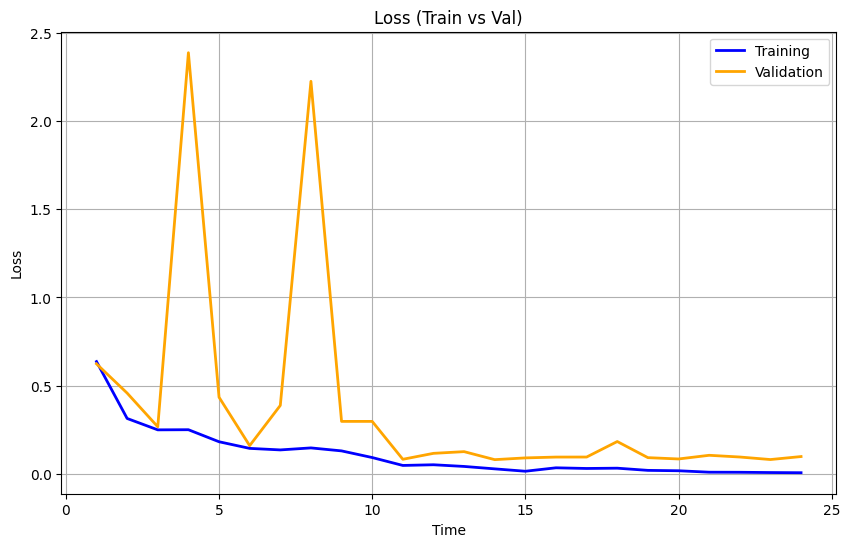

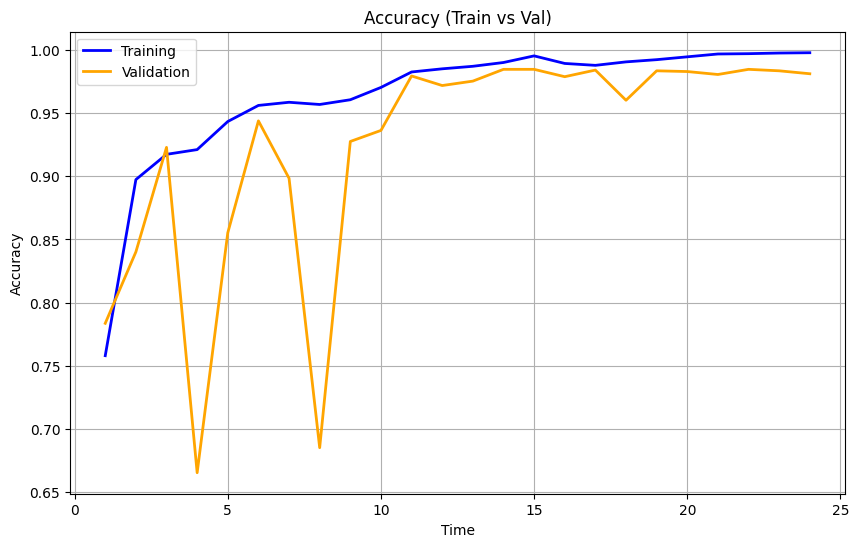

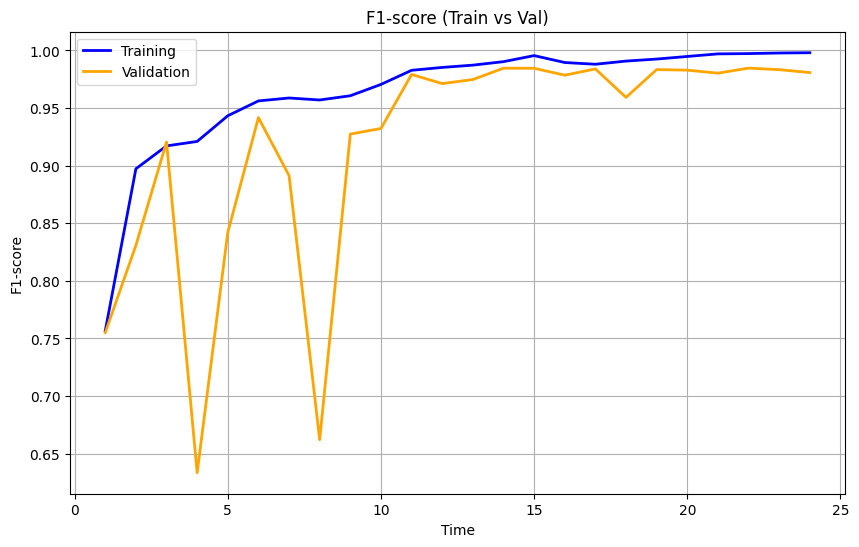

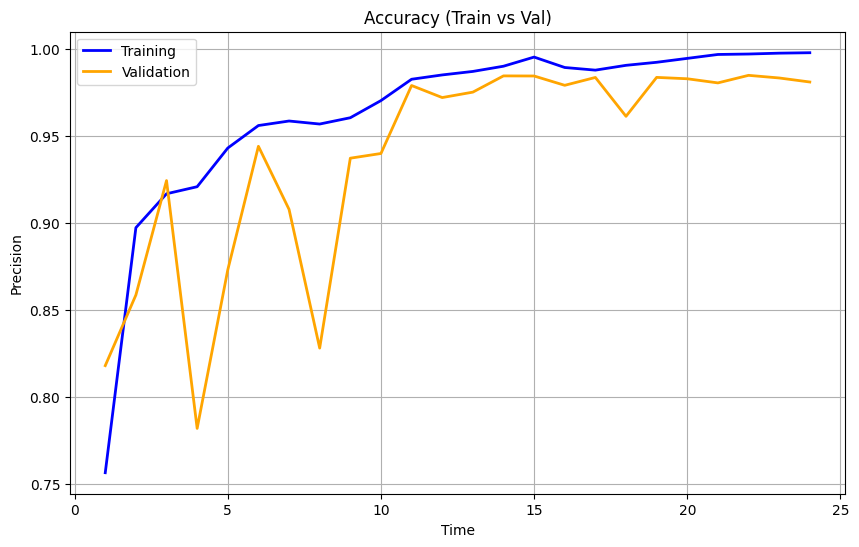

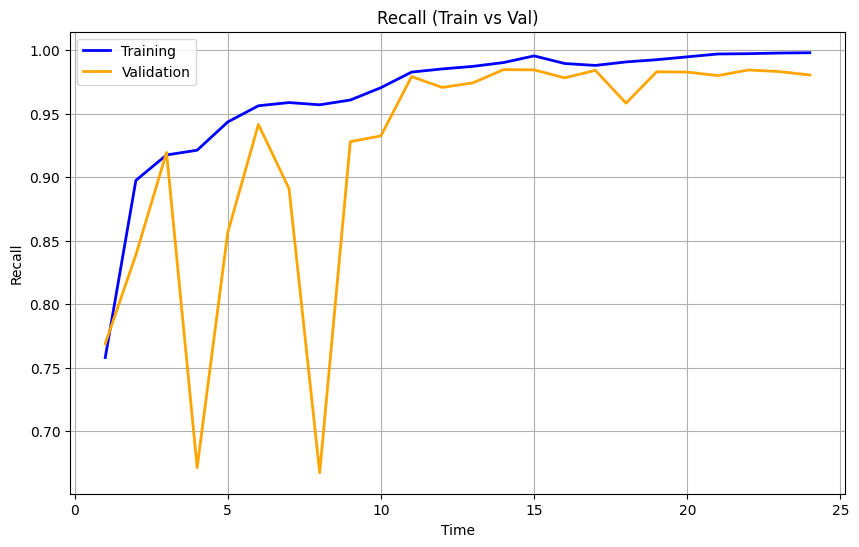

In [24]:
# Graph all metrics
plot_train_val_metric(
    train_losses,
    val_losses,
    "Loss (Train vs Val)",
    "Loss",
)
plot_train_val_metric(
    train_accuracies,
    val_accuracies,
    "Accuracy (Train vs Val)",
    "Accuracy",
)
plot_train_val_metric(
    train_f1s,
    val_f1s,
    "F1-score (Train vs Val)",
    "F1-score"
)
plot_train_val_metric(
    train_precisions,
    val_precisions,
    "Accuracy (Train vs Val)",
    "Precision",
)
plot_train_val_metric(
    train_recalls,
    val_recalls,
    "Recall (Train vs Val)",
    "Recall",
)

We also plotted the average between accuracy and recall.

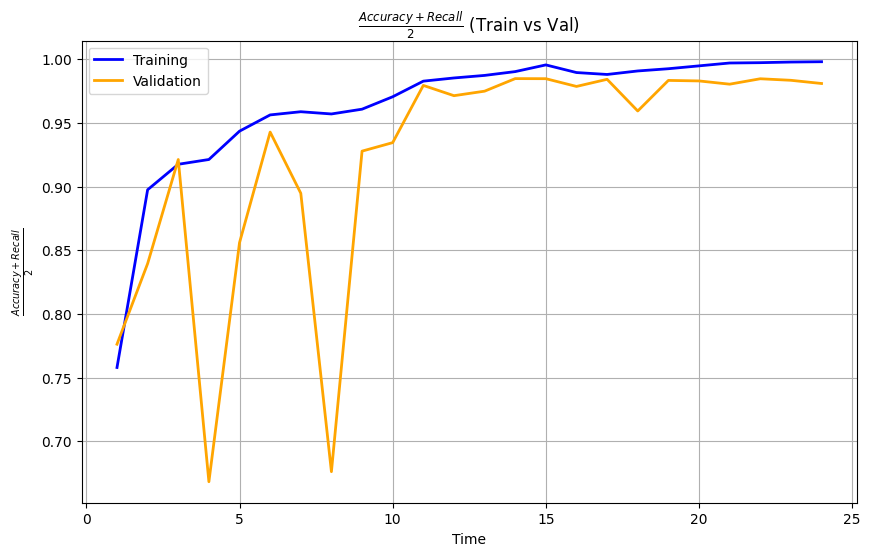

In [25]:
plot_train_val_metric(
    np.mean([train_accuracies, train_recalls], axis=0),
    np.mean([val_accuracies, val_recalls], axis=0),
    r"$\frac{Accuracy + Recall}{2}$ (Train vs Val)",
    r"$\frac{Accuracy + Recall}{2}$",
)

# Model evaluation

In [26]:
early_stopping.load_best_model(model);

In [27]:
# Test
model.eval()
epoch_test_loss = 0
all_test_preds = []
all_test_labels = []
all_test_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        epoch_test_loss += loss.item()

        # Apply softmax and obtain predictions
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(probs, 1)

        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())
        all_test_probs.extend(probs.cpu().numpy())

# Calculate test metrics
test_loss = epoch_test_loss / len(test_loader)
test_acc = accuracy_score(all_test_labels, all_test_preds)
test_precision = precision_score(
    all_test_labels, all_test_preds, average="macro", zero_division=0
)
test_recall = recall_score(
    all_test_labels, all_test_preds, average="macro", zero_division=0
)
test_f1 = f1_score(all_test_labels, all_test_preds, average="macro", zero_division=0)


In [28]:
class_names = label_encoder.classes_

print("Classification Report:")
print(
    classification_report(
        all_test_labels, all_test_preds, target_names=class_names, zero_division=0, digits=4
    )
)

Classification Report:
              precision    recall  f1-score   support

      glioma     1.0000    0.9767    0.9882       300
  meningioma     0.9712    0.9902    0.9806       306
     notumor     0.9975    0.9951    0.9963       405
   pituitary     0.9868    0.9933    0.9900       300

    accuracy                         0.9893      1311
   macro avg     0.9889    0.9888    0.9888      1311
weighted avg     0.9895    0.9893    0.9893      1311



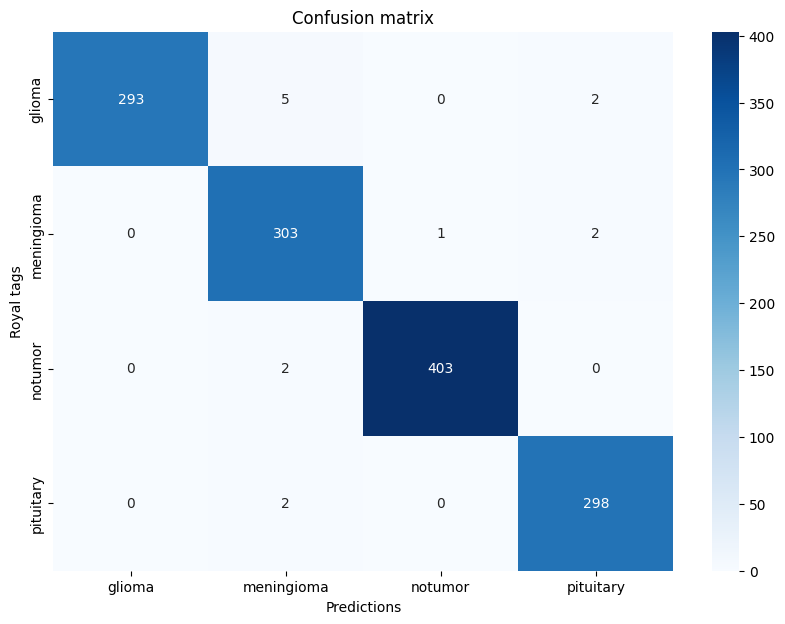

In [30]:
cm = confusion_matrix(all_test_labels, all_test_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predictions")
plt.ylabel("Royal tags")
plt.title("Confusion matrix")
plt.show()

In [37]:
error_type_I = []
error_type_II = []

for i in range(num_classes):
    FP = sum(cm[:, i]) - cm[i, i]  # False Positives
    FN = sum(cm[i, :]) - cm[i, i]  # False Negatives
    TP = cm[i, i]  # True Positives
    TN = cm.sum() - (FP + FN + TP)  # True Negatives

    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # Type I Error
    FNR = FN / (FN + TP) if (FN + TP) > 0 else 0  # Type II Error

    error_type_I.append(FPR)
    error_type_II.append(FNR)

df_errores = pd.DataFrame({
    'Class': class_names,
    'Type I Error (FPR)': error_type_I,
    'Type II Error (FNR)': error_type_II
})

pd.set_option('display.float_format', '{:.4g}'.format)
print(df_errores.to_string(index=False))

     Class  Type I Error (FPR)  Type II Error (FNR)
    glioma                   0              0.02333
meningioma            0.008955             0.009804
   notumor            0.001104             0.004938
 pituitary            0.003956             0.006667


# Grad-CAM for explainability
Grad-CAM is an explainability method for CNN models that generates heat maps indicating the key regions that contributed to the model's prediction. We will show three examples for each class, with the original image on the left and the heat map superimposed on the right, indicating the class the model predicted and which areas had the greatest impact on the prediction.

In [33]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Registrar hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        # Forward pass
        output = self.model(x)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1)

        # Backward pass
        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0][class_idx] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        # Calculate weights
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)

        # Calculate activation map
        cam = torch.sum(weights * self.activations, dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=x.shape[2:], mode="bilinear", align_corners=False)
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-10)

        return cam.squeeze().cpu().numpy(), class_idx

In [34]:
model.eval()
target_layer = model[1].features[25]
gradcam = GradCAM(model, target_layer)

In [35]:
def visualize_gradcam(val_loader, num_classes, num_examples=3):
    for class_idx in range(num_classes):
        class_name = label_encoder.inverse_transform([class_idx]).item()
        print(f"\nVisualizing examples for class {class_name}")
        examples_shown = 0

        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Filter by current class
            class_mask = labels == class_idx
            if not class_mask.any():
                continue

            class_images = images[class_mask]
            global img

            for img in class_images:
                img = img.unsqueeze(0)  # Add batch dimension

                # Get Grad-CAM
                cam, predicted_class = gradcam(img)
                true_class = class_name
                img_np = img.squeeze().cpu().numpy()

                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.imshow(img_np, cmap="gray")
                plt.title(f"Original (Clase: {true_class})")
                plt.axis("off")

                plt.subplot(1, 2, 2)
                plt.imshow(img_np, cmap="gray")
                plt.imshow(cam, cmap="jet", alpha=0.5, vmin=0, vmax=1)
                plt.title(
                    f"Grad-CAM (Pred: {label_encoder.inverse_transform(predicted_class.cpu()).item()})"
                )
                plt.axis("off")

                plt.show()

                examples_shown += 1
                if examples_shown >= num_examples:
                    break

            if examples_shown >= num_examples:
                break


Visualizing examples for class glioma


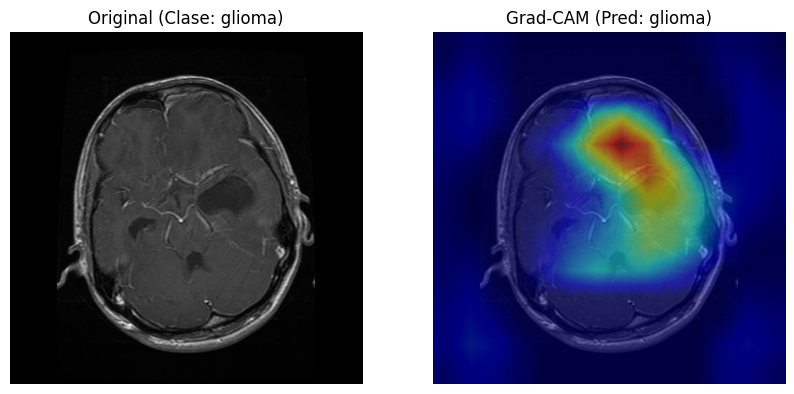

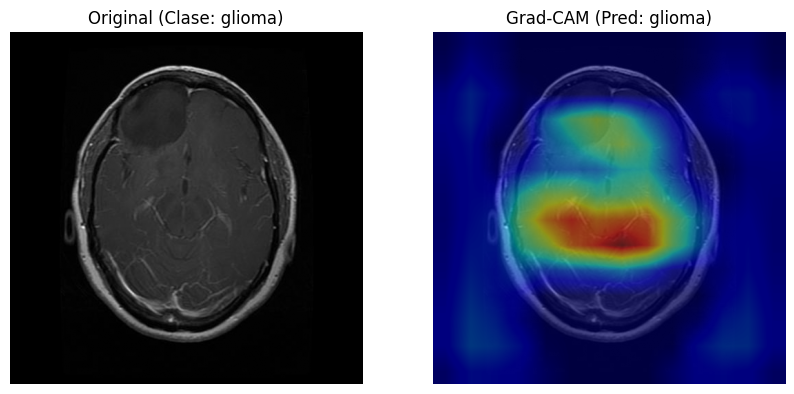

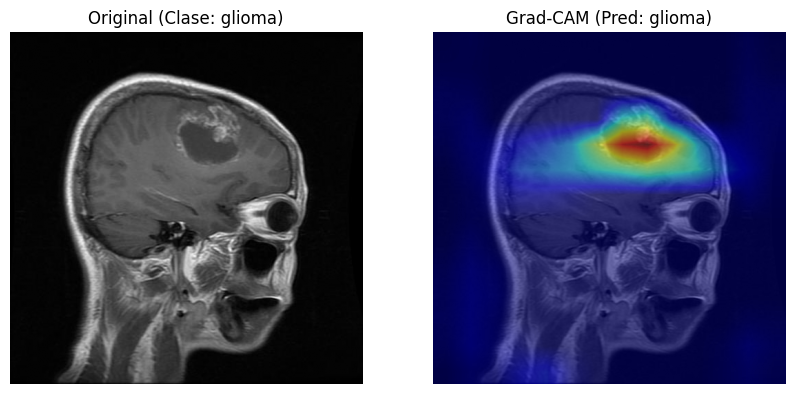


Visualizing examples for class meningioma


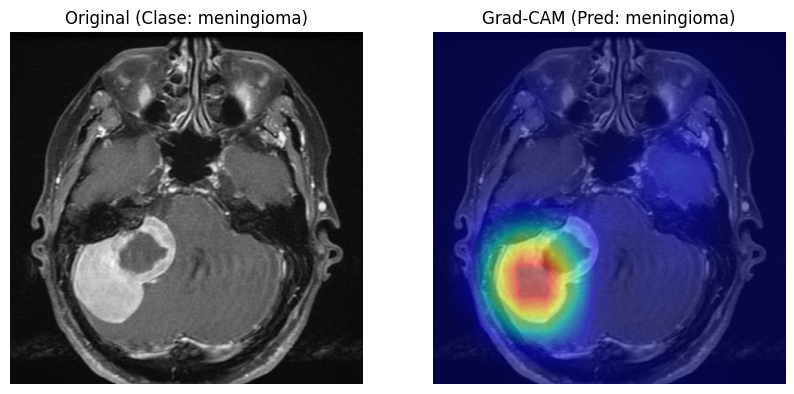

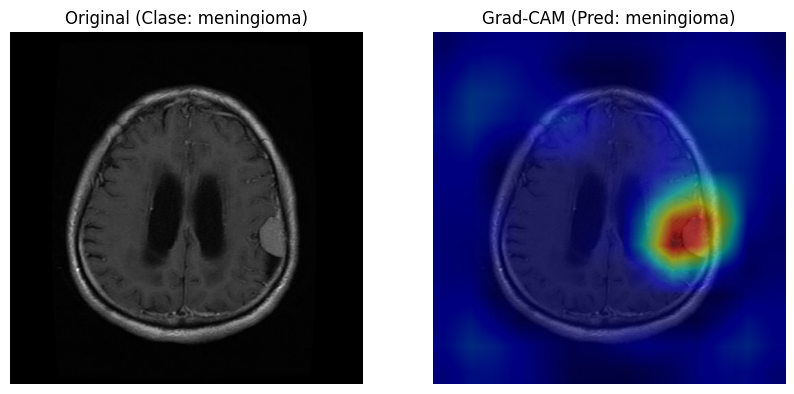

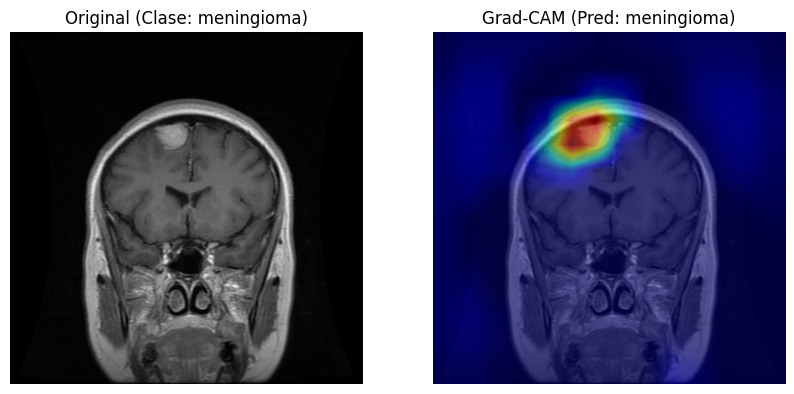


Visualizing examples for class notumor


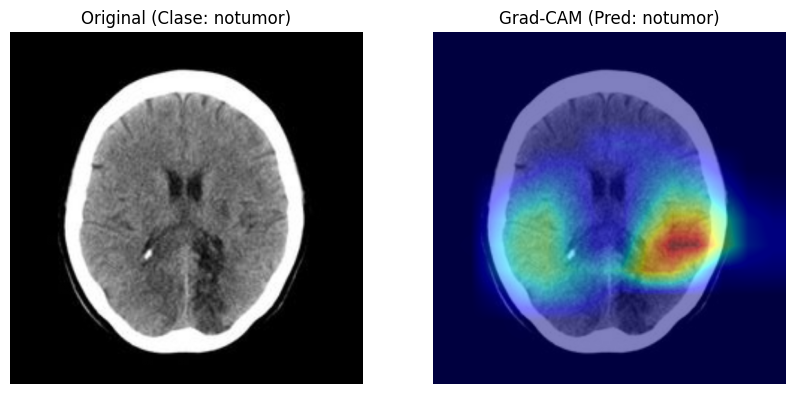

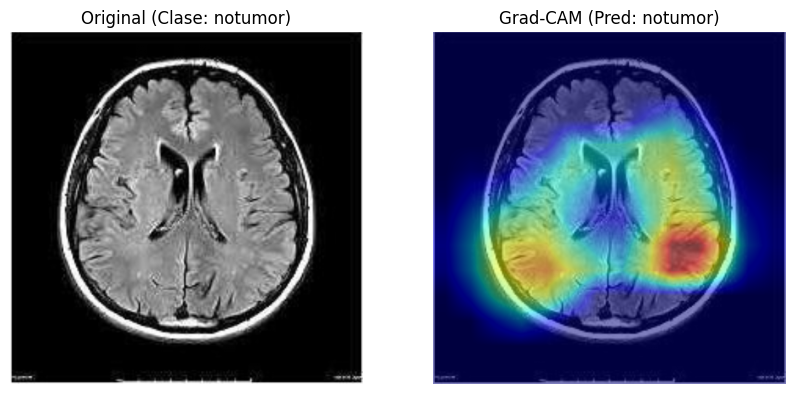

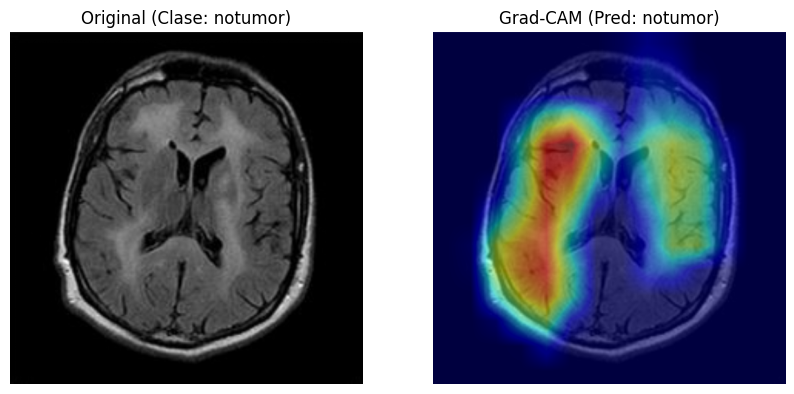


Visualizing examples for class pituitary


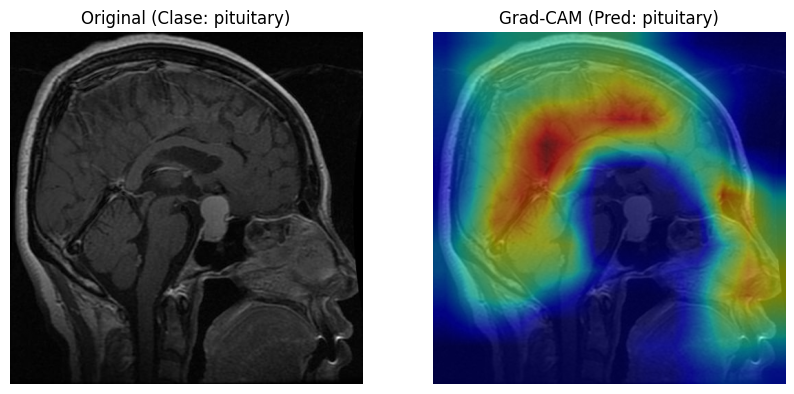

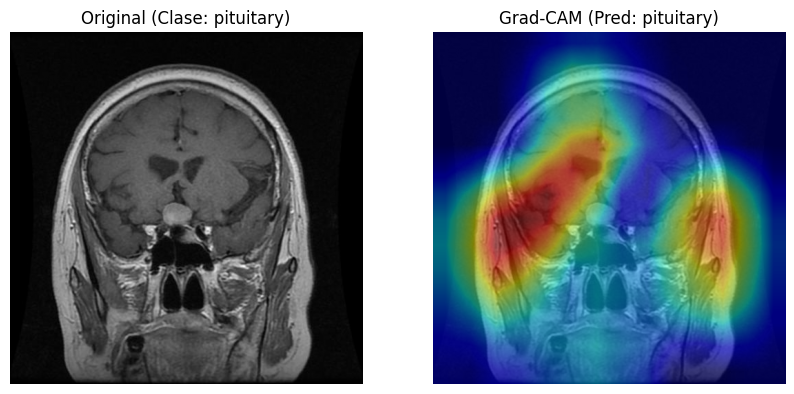

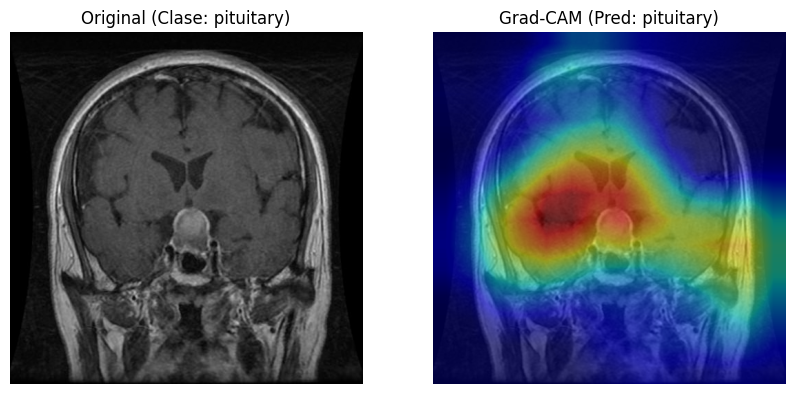

In [36]:
visualize_gradcam(test_loader, num_classes, num_examples=3)